## Consultas hacia _alfresco_

Este _notebook_ explora como hacer consultas de datos de audio del proyecto Sitios Permanentes de Calibración y Monitoreo de la Biodiversidad (SiPeCaM) de dos formas:

1. Usando la API de `alfresco` para descargar los metadatos asociados a los archivos de audio filtrados inicialmente. 
2. Usando los metadatos obtenidos en 1. se determina la ruta de los archivos para poder usarlos desde `alfresco webdav`.


En este ejemplo se van a filtrar archivos de audio grabados entre el 2021-10-01 y 2021-10-10 en el cúmulo 92. Para fines prácticos se pone un límite del búsqueda de 2 archivos. Inicialmente se realizará la consulta de los metadatos de uno de los archivos, y posteriormente se encuentra su ruta en `web-dav` para poder usarlo en procesamiento. 


**Nota:**

El usuario deber tener en el mismo directorio un archivo `.env` que contenga la `x-api-key` del _alfresco_ para poder realizar consultas. El archivo solo contiene una línea, de la siguiente forma:
```
X_API_KEY=<x-api-key>
API_ENDPOINT="https://api.conabio.gob.mx/alfresco/search/"
```


### Dependencias

In [1]:
%%capture
!pip3 install python-dotenv==0.19.2

In [1]:
import os
import base64
import datetime 
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yuntu import Audio
from dotenv import load_dotenv

#### Parámetros

En este ejemplo hacemos una consulta con los siguientes campos:

- START_DATE (str): Fecha de inicio de los archivos
- END_DATE (str): Fecha de final de los archivos
- CUMULO (int): Número del cúmulo SiPeCaM
- MAX_ITEMS (int): Número máximo de items en el query

In [2]:
## user parameters - alfresco query
START_DATE = "2021-10-01" # YYYY-MM-DD
END_DATE = "2021-10-10" # YYYY-MM-DD
CUMULO = 92 # INT
MAX_ITEMS = 2 # INT

## parameters to adjust local paths
WEBDAV_DIR = "/shared_volume/webdav_alfresco"
SIPECAMP_WD_DIR = "Sites/sipecam/documentLibrary"

## Funciones

In [3]:
def get_file_path(webdav_local_dir, project_dir, cumulo, metadata_path):
    web_dav_local_path = os.path.join(webdav_local_dir, project_dir, str(cumulo))
    adj_metadata_path = metadata_path.split("documentLibrary/")[-1]
    
    return os.path.join(web_dav_local_path, adj_metadata_path)

def login():
    try:
        session = requests.Session()
        session.headers.update({"x-api-key": os.getenv("X_API_KEY")})
        return session
    except Exception as e:
        print("Login failed: ", e)

def parse_query_audio(start_date, end_date, cumulo, maxitems, print_q = False):
    query = {"query": {"query": f"+TYPE: \"sipecamAudio:audiofileSipecam\" AND (sipecamAudio:Datetime: [{start_date} TO {end_date}]) AND (sipecam:CumulusName: \"{cumulo}\")",
      "language": "afts"
        },
    "include": ["properties", "path"],
     "paging": {"maxItems": f"{maxitems}"
        }
    }
    
    if print_q:
        print(json.dumps(query, indent=2, sort_keys=False))
    
    return query

def request_metadata(session, query):
    
    try:
        req = session.post(
            os.getenv("API_ENDPOINT"),
            data = json.dumps(query),
        )

        metadata = req.json()

        counts = metadata['list']['pagination']['count']
        print(f"Found metadata for {counts} files")
    
        return metadata
    
    except Exception as e:
        print("Error: ", e)
        


## Consulta de metadatos

- Crear _session_ de _alfresco_:


In [4]:
load_dotenv()
session = login()

- Definir query:

In [5]:
query = parse_query_audio(START_DATE, END_DATE, CUMULO, MAX_ITEMS, print_q = True)

{
  "query": {
    "query": "+TYPE: \"sipecamAudio:audiofileSipecam\" AND (sipecamAudio:Datetime: [2021-10-01 TO 2021-10-10]) AND (sipecam:CumulusName: \"92\")",
    "language": "afts"
  },
  "include": [
    "properties",
    "path"
  ],
  "paging": {
    "maxItems": "2"
  }
}


- Consulta de metadatos a la API

In [6]:
metadata = request_metadata(session, query)

Found metadata for 2 files


> Ejemplo de metadatos para un archivo:

In [7]:
audio_metadata_ex = metadata["list"]['entries'][0]
audio_metadata_ex

{'entry': {'isFile': True,
  'createdByUser': {'id': 'jdonlucas', 'displayName': 'Jaime Donlucas'},
  'modifiedAt': '2022-03-30T00:09:28.021+0000',
  'nodeType': 'sipecamAudio:audiofileSipecam',
  'content': {'mimeType': 'audio/x-wav',
   'mimeTypeName': 'WAV Audio',
   'sizeInBytes': 5760488,
   'encoding': 'UTF-8'},
  'parentId': '14712b52-7bbe-4136-89bb-d23b7d175af0',
  'createdAt': '2022-03-18T01:48:37.789+0000',
  'path': {'name': '/Company Home/Sites/cumulo-92/documentLibrary/3_92_0_1343/24E4C30453E1BE08/2021-10-09/audios/Audible',
   'isComplete': True,
   'elements': [{'id': '824c8ab7-d896-4a4f-9531-c794cb0b6b17',
     'name': 'Company Home',
     'nodeType': 'cm:folder',
     'aspectNames': ['cm:titled', 'cm:auditable', 'app:uifacets']},
    {'id': '3231f25b-2f7d-46d6-9254-7117621095b5',
     'name': 'Sites',
     'nodeType': 'st:sites',
     'aspectNames': ['cm:titled', 'cm:auditable', 'app:uifacets']},
    {'id': '260f63aa-3fce-458f-a080-b0b7e378d5e4',
     'name': 'cumulo-9

## Uso del archivo en alfresco webdav

Para consultar el archivo en `webdav` debemos encontrar la ruta completa del mismo. Se puede acceder a esta información de la sigueinte forma:

In [8]:
# ruta en web dat
web_dav_path = audio_metadata_ex["entry"]["path"]["name"]
file_name = audio_metadata_ex["entry"]["name"]
metadata_path = os.path.join(web_dav_path, file_name)

print("Metadata path:\n", "\t", metadata_path)

Metadata path:
 	 /Company Home/Sites/cumulo-92/documentLibrary/3_92_0_1343/24E4C30453E1BE08/2021-10-09/audios/Audible/c6f30d6e571782f985a758e8446961c4.WAV


Sin embargo, debemos ajustar el la ruta al directorio `webdav` que tenemos en nuestro ordenador. Este ajuste se realiza por medio de la función `get_file_path`, definida anteriormente.

In [9]:
audio_path_ex = get_file_path(WEBDAV_DIR, SIPECAMP_WD_DIR, CUMULO, metadata_path)

print("Audio path:\n", "\t", audio_path_ex)

Audio path:
 	 /shared_volume/webdav_alfresco/Sites/sipecam/documentLibrary/92/3_92_0_1343/24E4C30453E1BE08/2021-10-09/audios/Audible/c6f30d6e571782f985a758e8446961c4.WAV


Una vez encontrada la ruta del archivo localmente en `webdav`, se puede usar el mismo para ejercicios de procesamiento. Por ejemplo, en este caso, realizaremos un gráfico del arreglo que representa el archivo de audio. 

<AxesSubplot:>

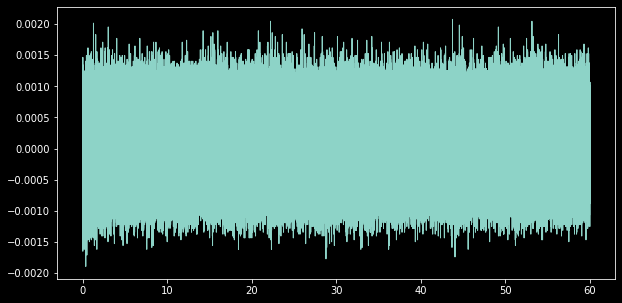

In [10]:
sample_rate = audio_metadata_ex["entry"]["properties"]["sipecamAudio:SampleRate"]
# audio object
audio = Audio(path=audio_path_ex, samplerate=sample_rate, timeexp=1.0)
# plot
plt.style.use('dark_background')
audio.plot(figsize=(10, 5))